# Software development patterns through git data mining

In [1]:
import sys, os, getpass, warnings
warnings.filterwarnings('ignore')
from patterns.visualizer import Visualizer

Create a `Visualizer` object for a project, e.g., for Spack, `vis = Visualizer('spack')`. This brings in data from database and annotate it with *locc*, *locc+*, *locc-*, *change-size-cos* = *1-similarity* (**expensive call**). The data is cached locally after it's fetched from the database and subsequently loaded from disk, unless you specify the `cache=False` parameter, e.g., `vis.get_data(cache=False)`. Available projects include `'lammps', 'spack', 'petsc', 'Nek5000', 'nwchem', 'E3SM', 'qmcpack', 'qdpxx'` (the full list can be obtained with by calling the `Visualizer()` constructor without arguments.

The `get_data` method automatically removes changes associated with non-code files. The determination of what is code is made by including common suffixes, as well as checking manually a sampling of ECP projects for the suffixes used for things that can be labeled as code (vs. input simulation data, documentation, or generated files), for a list of suffixes, refer to the `Patterns.code_suffixes` list in [patterns.py](https://github.com/HPCL/ideas-uo/blob/master/src/patterns/patterns.py). This makes the analysis of decades of project data feasible. You can disable this if desired, by passing the `code_only=False` parameter to `get_data`. You can also explicitly remove non-code rows with `vis.remove_noncode()`.

In [2]:
vis = Visualizer(project_name='lammps')
vis.get_data()

INFO: Loaded local cached copy of lammps data.
INFO: Cleaning up data and computing averages...
INFO: Done computing averages. 82494 commits (code only)


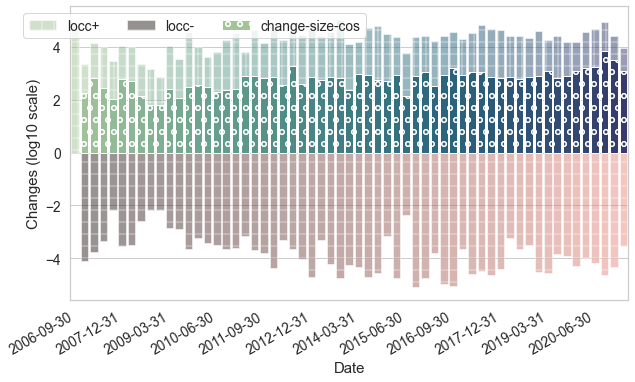

In [3]:
df = vis.plot_overall_project_locc(log=True)

to focus on a given year and/or month, set *year* and *month* fields

In [4]:
vis.set_year(2019)
vis.set_month(10)

to plot for a given year, provide *time_range='year'*

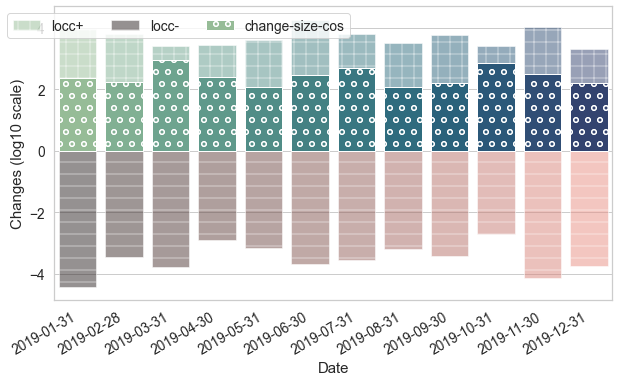

In [5]:
df = vis.plot_overall_project_locc(time_range='year',log=True)

similarly to plot for a given month, set *time_range='month'*

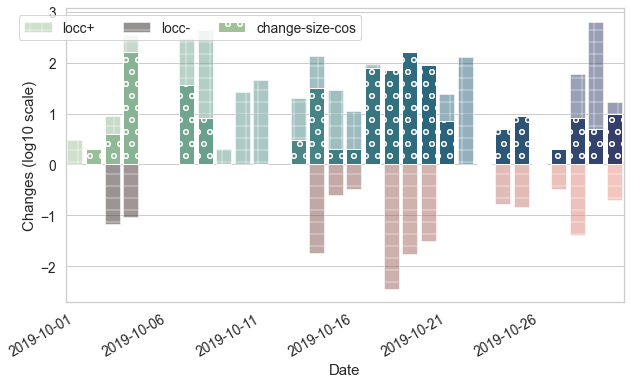

In [6]:
df = vis.plot_overall_project_locc(time_range='month',log=True)

### Finding trends with averages
We can plot the annual averages timeline for the entire project's history (by default showing LOCC and cos distance) with `plot_total_avg`. Several moving average plots are available, with different aggregation granularities (year, month) and different sliding window sizes.

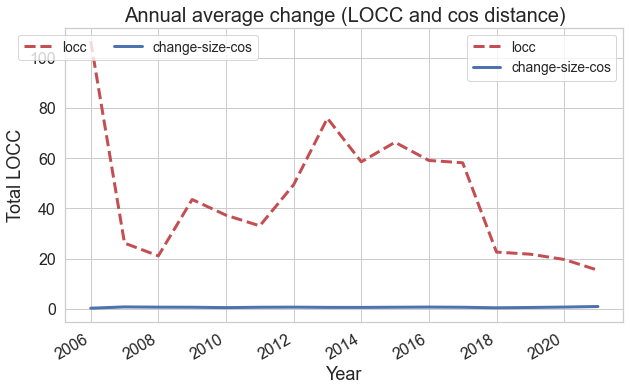

In [7]:
vis.plot_total_avg()

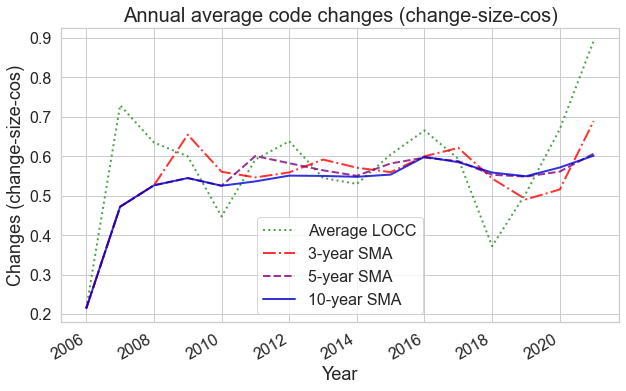

In [8]:
vis.plot_total_moving_avgs()

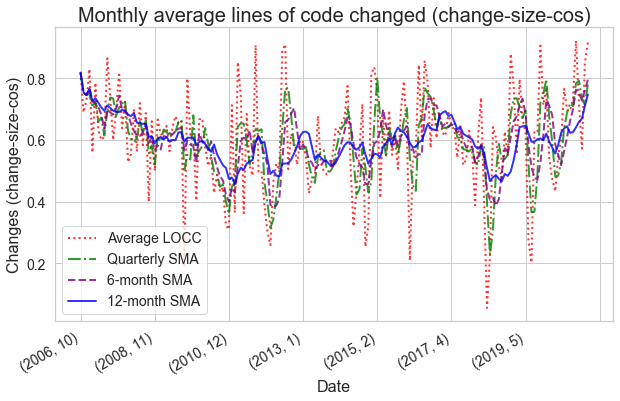

In [9]:
vis.plot_total_moving_avgs_M()

## More timelines
This reflects changed lines of code as reported in git commit diffs. We have two functions that generate timeline plots of a change metric: `plot_proj_change_line` and `plot_proj_change_bubble`. By default, they show the entire range of selected dates and use the cos distance metric. You can specify a different metric with the `locc_metric` argument, e.g., `vis.plot_proj_change_line(locc_metric='locc')`

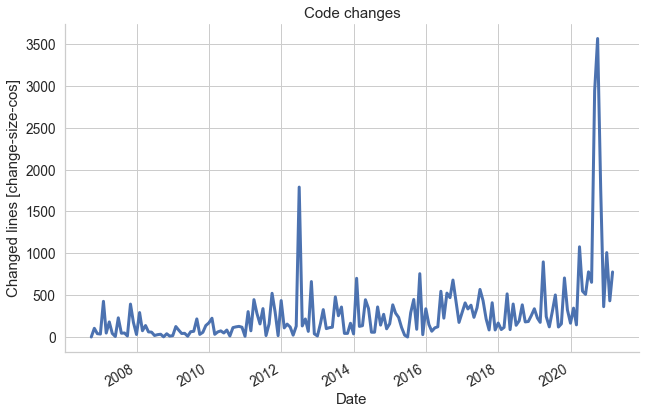

In [10]:
df = vis.plot_proj_change_line()

And looking at both line counts (LOCC) and the distance based `change-size-cos` at the same time. If not specified, the time_range argument defaults None, which indicates the entire time period of the dataset.

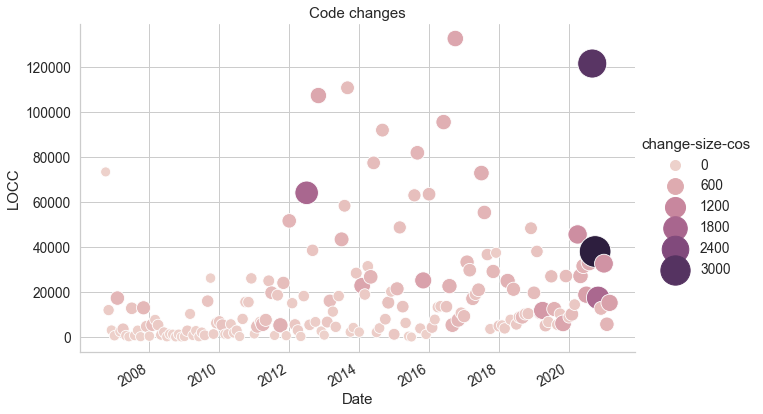

In [11]:
df = vis.plot_proj_change_bubble(time_range=None)

We can choose to zoom into a specific year, recall that previously we did `vis.set_year(2020)`.

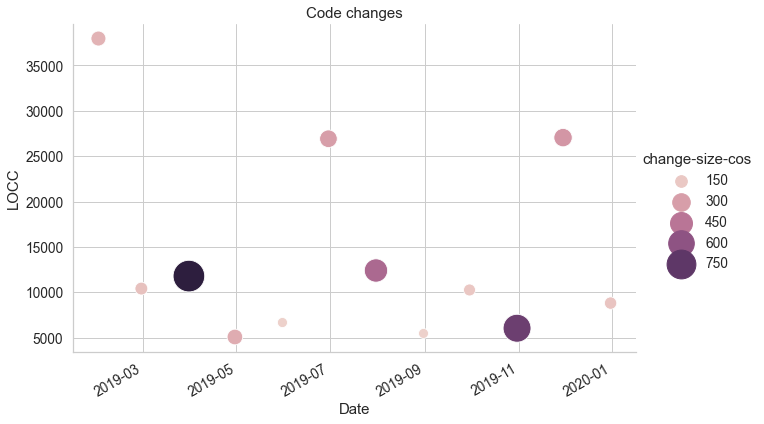

In [12]:
df = vis.plot_proj_change_bubble(time_range='year')

Or a specific year range.

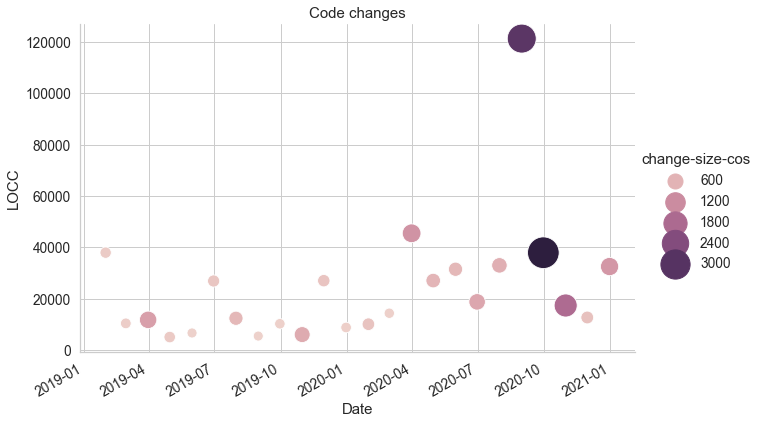

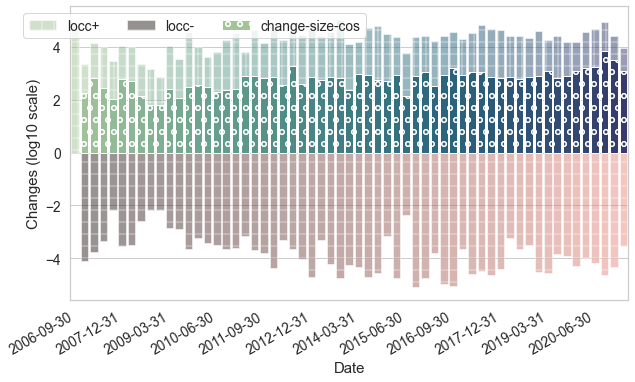

In [13]:
vis.select_year_range(2019,2020)
vis.plot_proj_change_bubble(time_range='year-year')
df = vis.plot_overall_project_locc(time_range='year-year',log=True)

We can also zoom into a single month; recall we previously did:
```
vis.set_year(2019)
vis.set_month(10)
```

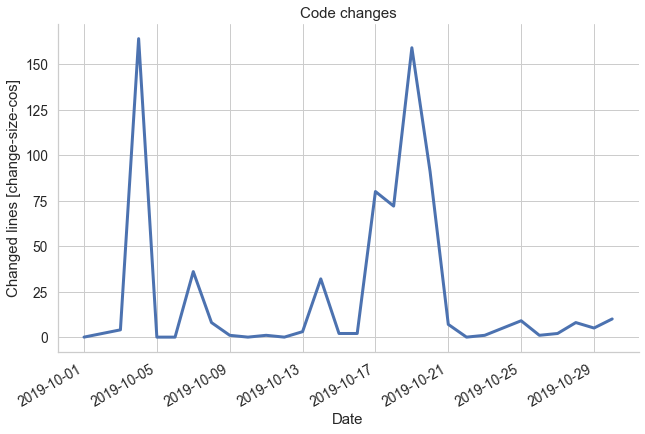

In [14]:
_ = vis.plot_proj_change_line(time_range='month')

Or a month range

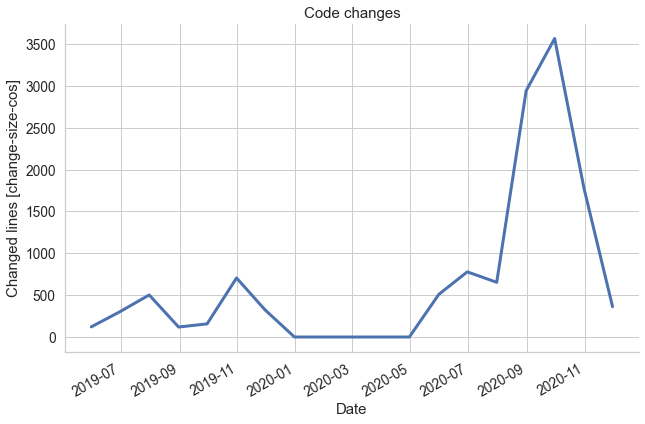

In [15]:
vis.select_month_range(5,11)
df = vis.plot_proj_change_line(time_range='month-month')

## Using a distance metric to adjust the size of the changes

We use the python [textdistance](https://github.com/life4/textdistance) module. The following algorithms have been integrated with the visualizer.
```
'cos', 'hamming', 'damerau_levenshtein', 'jaccard', 'jaro', 'jaro_winkler', 'bag', 'editex'
```
Any of the above plots can be made with any line counting metric, typically specified through the `locc_metric` argument.

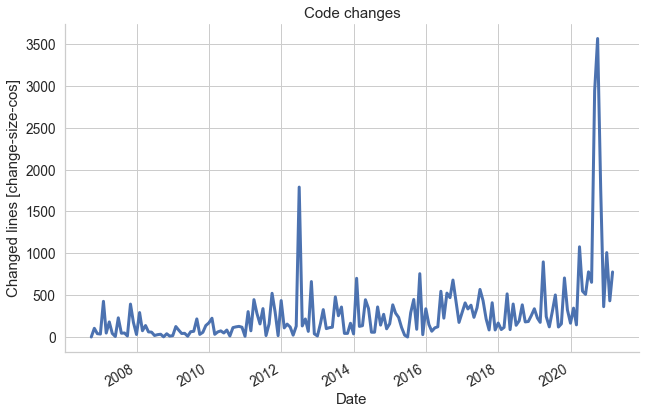

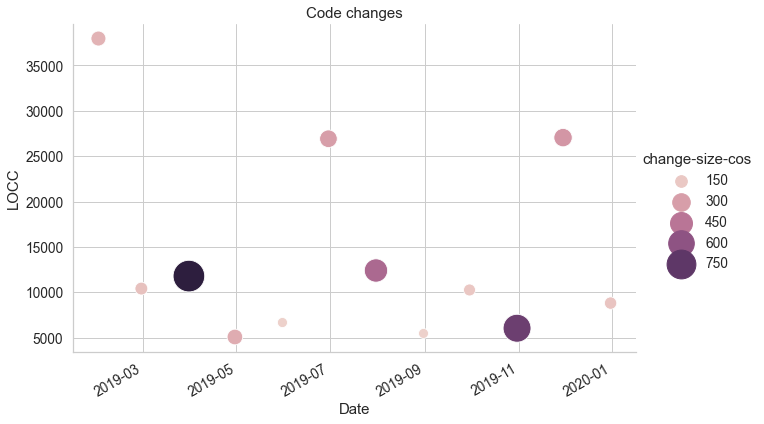

In [16]:
vis.set_diff_alg('jaccard')
df = vis.plot_proj_change_line()
_ = vis.plot_proj_change_bubble()

## More patterns
Here we look at a combination of the the high-churn and domain champion patterns. Basically we are focusing on the files that have the most changes and restricting the developers by those with the biggest contributions. One tricky issue that makes this nontrivial is that contributors use different names for their contributions. We have implemented a fuzzy name matching scheme of author names using the python `fuzzywuzzy` package to consolidate single-author contributions as much as possible.

INFO: Creating developer matrix...


unique_author,sjplimp,Stan Moore,Axel Kohlmeyer,Stan Gerald Moore (stamoor),Steven J Plimpton,Tom Swinburne,pscrozi,julient31,Richard Berger,Anne Gunn
filepath,,,,,,,,,,
lib/kokkos/tpls/gtest/gtest/gtest-all.cc,0,44343,0,9854,0,0,0,0,0,0
lib/kokkos/tpls/gtest/gtest/gtest.h,0,105462,0,23436,0,0,0,0,0,0
src/KSPACE/pppm.cpp,23380,2,1091,1,286,223,3124,6,0,66
src/KSPACE/pppm_disp.cpp,19489,4,293,0,59,25,2,0,0,220
src/MANYBODY/pair_bop.cpp,19036,0,494,0,4,670,0,0,509,230


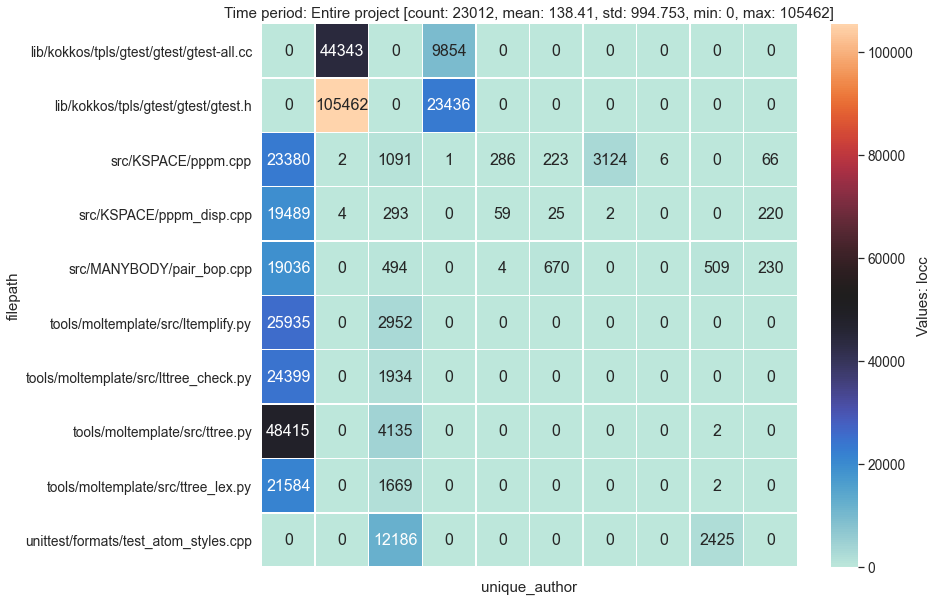

In [17]:
N = 10
vis.reset()
vis.set_max_label_length(30)
top_N = vis.plot_top_N_heatmap(N, locc_metric='locc')
top_N.head()

INFO: Creating developer matrix...


unique_author,sjplimp,Axel Kohlmeyer,Stan Moore,Anne Gunn,Steven J Plimpton,Stan Gerald Moore (stamoor),Richard Berger,Sebastian Hütter,Tom Swinburne,julient31
filepath,,,,,,,,,,
src/KSPACE/pppm.cpp,84,14,1,2,6,0,0,1,1,1
src/RIGID/fix_rigid_small.cpp,47,30,0,2,15,0,4,0,1,0
src/atom.cpp,99,42,1,4,10,0,5,0,4,3
src/comm.cpp,70,25,1,2,14,0,0,0,1,0
src/input.cpp,94,40,1,4,1,0,2,1,0,0


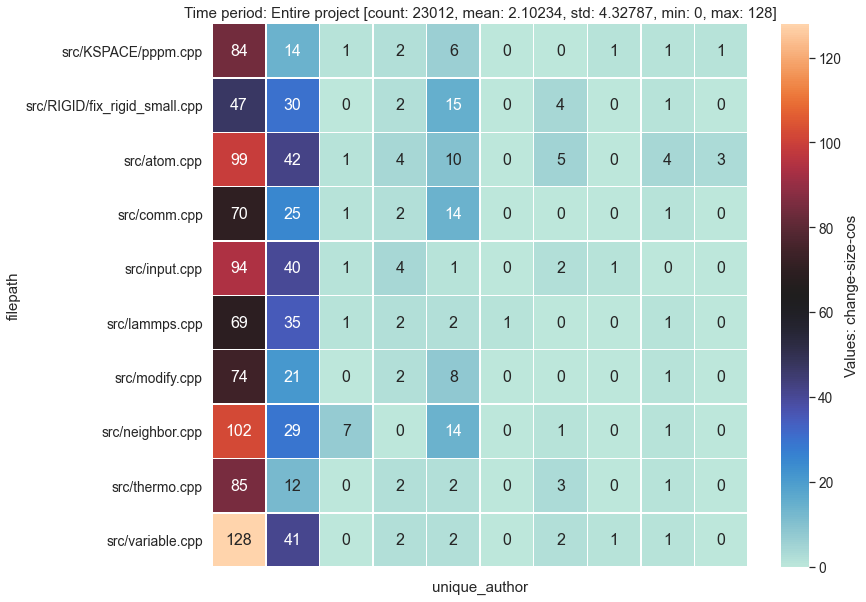

In [18]:
top_N_cos = vis.plot_top_N_heatmap(N, locc_metric='change-size-cos')
top_N_cos.head()

We can also easily see the exact differences between different ways of measuring change.

In [19]:
file_dev_locc, _ = vis.make_file_developer_df(locc_metric='locc')
file_dev_diff, _ = vis.make_file_developer_df(locc_metric='change-size-cos')

INFO: Creating developer matrix...
INFO: Creating developer matrix...


Total number of developers: 173
INFO: Creating developer matrix...


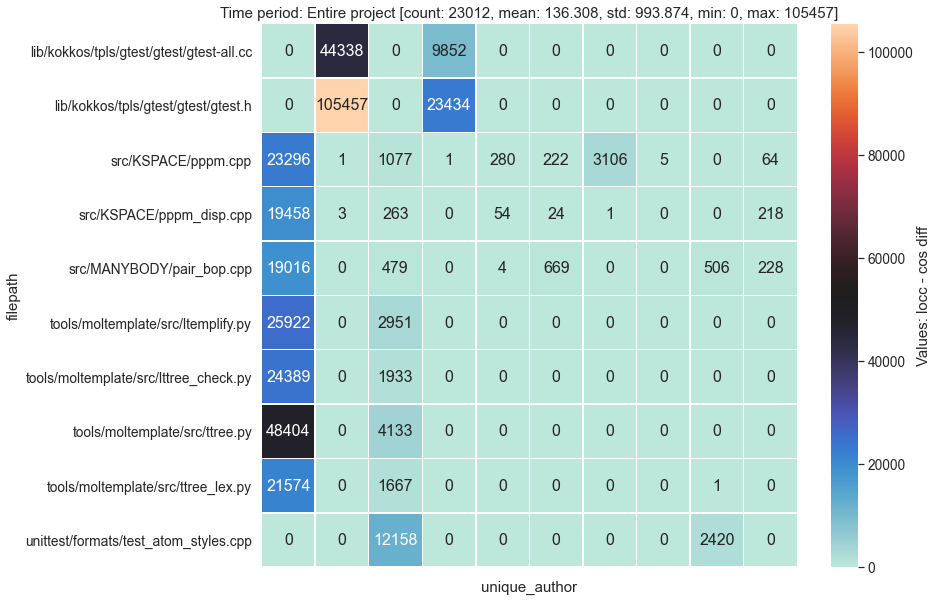

In [20]:
diff_df = file_dev_locc.sub(file_dev_diff, axis=0)
print("Total number of developers: %d" % diff_df.shape[1])
diff_df.head()
df = vis.commit_data
df['locc - cos diff'] = df['locc']-df['change-size-cos']
d = vis.plot_top_N_heatmap(top_N = 10, locc_metric='locc - cos diff', my_df=df)

We can generate the "hot-files" data for any time period, the way we select it is the same as previously described.

INFO: Creating developer matrix...


unique_author,Michael Brown,Axel Kohlmeyer
filepath,,
lib/gpu/lal_atom.h,589,0
lib/gpu/lal_device.cpp,414,0
lib/gpu/lal_neighbor.cpp,281,0
lib/gpu/lal_sw.cu,560,0
lib/gpu/lal_tersoff.cu,817,0


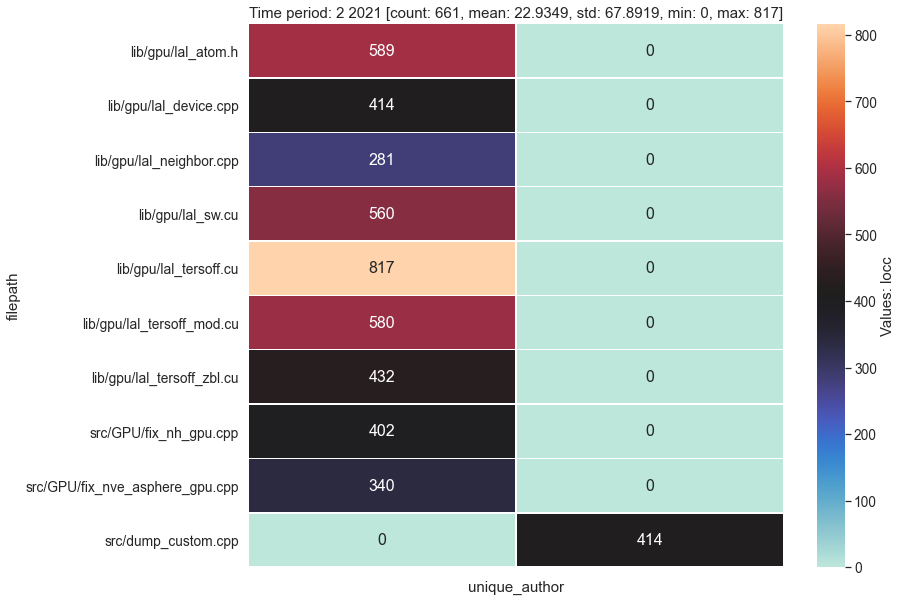

In [21]:
N = 10
vis.set_year(2021)
vis.set_month(2)
vis.set_max_label_length(30)
top_N = vis.plot_top_N_heatmap(N, time_range="month",locc_metric='locc')
top_N.head()

## Did anything unusual happen in 2020?
This specific function looks at how 2020 contributions compare with the average (v

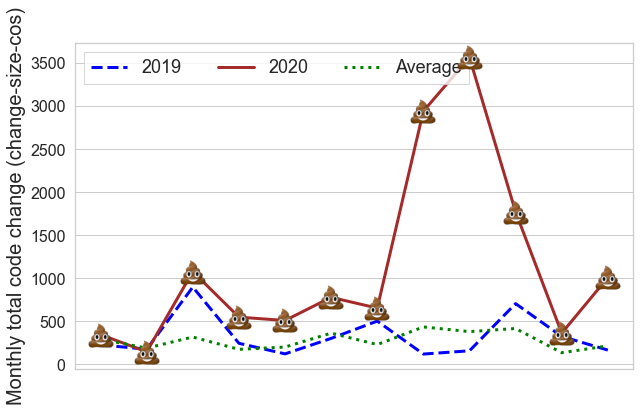

In [22]:
vis.how_was_2020('change-size-cos')

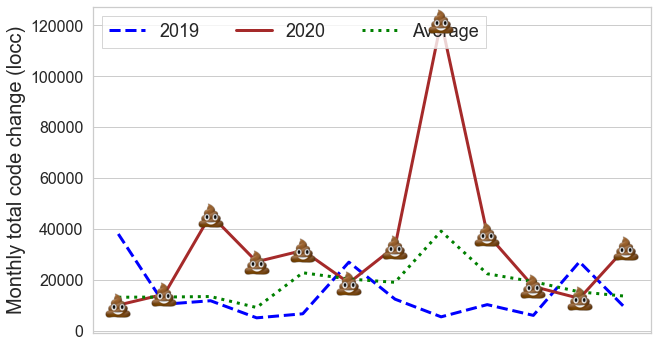

In [23]:
vis.how_was_2020('locc')